# A highly predictive signature (HPS) of Alzheimer's disease dementia from cognitive and structural brain features

This notebook uses simulated data from the Alzheimer's Disease Neuroimaging Initiative (ADNI) to make high confidence predictions to classify patients with mild cognitive impairment (MCI) who will progress to Alzheimer's disease dementia within three years from those who will remain cognitively stable.

This notebook is associated with the following preprint [A signature of cognitive deficits and brain atrophy that is highly predictive of progression to Alzheimer's dementia](https://doi.org/10.1101/352344)

#### import packages

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from copy import deepcopy

# import sklearn modules
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# import proteus modules
from Proteus.proteus.visu import sbp_visu
from Proteus.proteus.predic import high_confidence_at
from Proteus.proteus.predic import prediction

/home/angela/anaconda3/envs/vcog_paper_py35/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### function for stats of prediction

In [2]:
def predic_stats(y_, y_pred, lr_decision):
    # number of AD subjects
    n_ad = sum(y_)
    print('Total number of TARGET subjects: ', n_ad)

    # number of CN subjects
    n_cn = len(y_) - sum(y_)
    print('Total number of NON-TARGET subjects: ', n_cn)
    
    # number of subjects predicted as AD at stage 1
    n_pos = sum(y_pred)
    print('Stage 1 number of hits (true and false positives): ', n_pos)
    
    # true positives at stage 1
    n_pos_ad = sum(y_pred[y_.astype(bool)])
    print('Stage 1 TRUE positives: ', n_pos_ad)
    
    # false positives at stage 1
    n_pos_cn = n_pos - n_pos_ad
    print('Stage 1 FALSE positives: ', n_pos_cn)
    
    # number of CN subjects not identified as positive (true negatives)
    n_neg1_cn = n_cn - n_pos_cn
    print('Stage 1 TRUE negatives: ', n_neg1_cn)

    # number of all flagged HPC-AD subjects
    n_flag = sum(y_pred[lr_decision>0])
    print('Total number of flagged HPC-AD subjects: ', n_flag)

    # number of flagged HPC-AD subjects who are actually AD (true positives)
    y_pred_true = y_ + y_pred
    y_pred_true = y_pred_true==2
    n_flag_ad = sum(y_pred_true[lr_decision>0])
    print('Number of flagged HPC-AD subjects that are TRUE positives: ', n_flag_ad)

    # number of flagged HPC-AD subjects that are actually CN (false positives)
    n_flag_cn = n_flag - n_flag_ad
    print('Number of flagged HPC-AD subjects that are FALSE positives: ', n_flag_cn)

    # number of CN subjects that were not flagged (true negatives)
    n_neg_cn = n_cn - n_flag_cn
    print('Number of true negatives: ', n_neg_cn)
    
    print('#############################')
    print('Stage 1 stats for TARGET vs NON-TARGET')
    print('Precision for AD: ', n_pos_ad/(n_pos_ad + n_pos_cn))
    prec = n_pos_ad/(n_pos_ad + n_pos_cn)
    print('Recall (or sensitivity)  for AD: ', n_pos_ad/n_ad)
    sens = n_pos_ad/n_ad
    print('Specificity: ', n_neg1_cn/n_cn)
    spec = n_neg1_cn/n_cn
    fp = (1-spec)*664
    tp = sens*336
    adj_prec = tp/(tp+fp)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec)
    print('Accuracy: ', (n_pos_ad + n_neg1_cn)/(n_ad + n_cn))
    acc = (n_pos_ad + n_neg1_cn)/(n_ad + n_cn)

    print('#############################')
    print('Stage 2 stats for TARGET vs NON-TARGET')
    print('Precision for HPC-AD: ', n_flag_ad/n_flag)
    prec_2 = n_flag_ad/n_flag
    print('Recall (or sensitivity) for HPC-AD: ', n_flag_ad/n_ad)
    sens_2 = n_flag_ad/n_ad
    print('Specificity: ', n_neg_cn/n_cn)
    spec_2 = n_neg_cn/n_cn
    fp_2 = (1-spec_2)*664
    tp_2 = sens_2*336
    adj_prec_2 = tp_2/(tp_2 + fp_2)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec_2)
    print('Accuracy: ', (n_flag_ad + n_neg_cn)/(n_ad + n_cn))
    acc_2 = (n_flag_ad + n_neg_cn)/(n_ad + n_cn)
    
    return sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2

#### set the random seed

In [3]:
np.random.seed(1)

# Load simulated data

We created simulated data derived from the ADNI dataset and hosted it on [Figshare](https://figshare.com/articles/Simulated_cognitive_and_structural_MRI_data_from_ADNI/7132757). The following URL request will retrieve these data and load them using pandas.

In [4]:
# Download the csv file from the web
urllib.request.urlretrieve("https://ndownloader.figshare.com/files/13123139","simulated_data.csv")

('simulated_data.csv', <http.client.HTTPMessage at 0x7f3941ce5278>)

In [5]:
# read the data with pandas
data = pd.read_csv('simulated_data.csv')

In [6]:
# create 1-hot variable for initial AD diagnosis
for i,row in data.iterrows():
    dx = row['DX']
    if dx == 'Dementia':
        data.loc[i,'AD'] = 1
    else:
        data.loc[i,'AD'] = 0

# Train a model to classify patients with AD dementia vs cognitively normal (CN) subjects

In this section, we will train a machine learning model to classify patients with AD dementia from cognitively normal subjects in ADNI1. This section displays the code that was used to generate the results presented in *"Prediction of AD dementia vs cognitively normal individuals"* and *"Identification of easy AD cases for prediction"* in the *Results* section of the preprint.

We used [Proteus](https://github.com/SIMEXP/vcog_hps_ad/tree/master/Proteus) which is built on top of [scikitlearn](http://scikit-learn.org) to generate our predictive models.

#### Organize the data for the training set

In [7]:
# grab only adni1 subjects
train_set = data[data.dataset != 'ADNI2']

In [8]:
# grab only Dementia & CN subjects
train_set = train_set[train_set.DX != 'pMCI']
train_set = train_set[train_set.DX != 'sMCI']

In [9]:
# set instance of standard scaler
scaler = preprocessing.StandardScaler()

# define the x and y variables
x_ = train_set.iloc[:,train_set.columns.get_loc("ADAS13"):train_set.columns.get_loc("sub7")+1].values
y_ = train_set[['AD']].values.ravel()

# add these variables to the x
confounds = train_set[['gender','age_scan','mean_gm','tiv']].values

# scale the x variables
x_ = scaler.fit_transform(np.hstack((x_,confounds)))

#### Cross-validation of the classifier in ADNI1 AD & CN

In [10]:
s1_spec = []
s1_sens = []
s1_prec = []
s1_acc = []

s2_spec = []
s2_sens = []
s2_prec = []
s2_acc = []

skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(x_,y_):
    X_training, X_val = x_[train_index], x_[val_index]
    y_training, y_val = y_[train_index], y_[val_index]
    
    # parameters of classifier
    hpc = high_confidence_at.TwoStagesPrediction(
        n_iter=500,
        shuffle_test_split=0.5,
        min_gamma=.99,
        thresh_ratio=0.1)
    
    # train the model
    hpc.fit(X_training, X_training, y_training)
    
    # test in separate sample
    _, dic_results = hpc.predict(X_val, X_val)
    
    print('Classifying AD vs CN at stage 2...')
    print((dic_results['s1df'][:,0]>0).astype(float))
    # get the predicted labels from stage 2
    y_pred = (dic_results['s1df'][:,0]>0).astype(float)
    lr_decision = dic_results['s2df'][:,1]
    
    # print statistics of prediction
    sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2 = predic_stats(y_val, y_pred, lr_decision)
    s1_spec.append(spec)
    s1_sens.append(sens)
    s1_prec.append(prec)
    s1_acc.append(acc)
    s2_spec.append(spec_2)
    s2_sens.append(sens_2)
    s2_prec.append(prec_2)
    s2_acc.append(acc_2)
    
    print('------------------------------------------------------')

Stage 1
Proba:
[1.         0.93076923 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.85062241 1.         1.
 1.         1.         1.         0.99579832 1.         1.
 1.         1.         0.90725806 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.996139   1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.     

Average hm score 0.8502024291497976
Stage 2
Adjusted gamma:  1.0
Adjusted gamma:  1.0
Classifying AD vs CN at stage 2...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Total number of TARGET subjects:  54.0
Total number of NON-TARGET subjects:  68.0
Stage 1 number of hits (true and false positives):  57.0
Stage 1 TRUE positives:  54.0
Stage 1 FALSE positives:  3.0
Stage 1 TRUE negatives:  65.0
Total number of flagged HPC-AD subjects:  50.0
Number of flagged HPC-AD subjects that are TRUE positives:  49
Number of flagged HPC-AD subjects that are FALSE positives:  1.0
Number of true negatives:  67.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
P

#### Mean stats of prediction across the k folds from cross-validation

These average cross-validated statistics are presented as the results of the AD vs CN classification in ADNI1. Stage 1 represents the basic support vector machine (SVM) with a linear kernel, while Stage 2 represents the two-stage classifier that makes high confidence predictions. The statistics for Stage 1 are reported under *"Prediction of AD dementia vs cognitively normal individuals"* in the *Results* section of the paper. The statistics for Stage 2 are reported under *"Identification of easy AD cases for prediction"* in the *Results* section of the paper.

In [11]:
print('Stage 1')
print('Mean sensitivity: ', np.mean(s1_sens))
print('Mean specificity: ', np.mean(s1_spec))
print('Mean precision: ', np.mean(s1_prec))
print('Mean accuracy: ', np.mean(s1_acc))
print('#'*10)
print('Stage 2')
print('Mean sensitivity: ', np.mean(s2_sens))
print('Mean specificity: ', np.mean(s2_spec))
print('Mean precision: ', np.mean(s2_prec))
print('Mean accuracy: ', np.mean(s2_acc))

Stage 1
Mean sensitivity:  0.8606060606060607
Mean specificity:  0.9706592782040353
Mean precision:  0.9607474568774879
Mean accuracy:  0.9218452403984642
##########
Stage 2
Mean sensitivity:  0.7570145903479236
Mean specificity:  0.9950980392156863
Mean precision:  0.9933333333333333
Mean accuracy:  0.8893238403563307


#### Train highly predictive model on whole training set of ADNI1 AD & CN

We will train the highly predictive classifier on the entire set of AD and CN subjects in ADNI1. The resulting model is what we will use for the rest of the classifications in other samples.

In [12]:
# create instance of classifier
hpc = high_confidence_at.TwoStagesPrediction(
    n_iter=500,
    shuffle_test_split=0.5,
    min_gamma=.99,
    thresh_ratio=0.1)

# train on the data
hpc.fit(x_, x_, y_)

Stage 1
Proba:
[1.         1.         1.         1.         0.28404669 1.
 1.         1.         1.         0.47257384 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99215686 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.86770428 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.     

#### Print the coefficients of each feature in the highly predictive model

In [13]:
hpc.confidencemodel.clfs[1].coef_

array([[ 8.43851668, -5.22286411, -3.53234506, -3.13500374, -1.88113384,
         0.        ,  0.08946603, -1.66361914,  0.10769513,  0.        ,
         0.80499281, -1.58166452, -0.03631993, -0.22931601, -0.93913661,
        -1.10079405]])

#### Plot the model weights

The following plot is presented in Figure 4 of the paper.

In [14]:
# plot weights from the model
w_df = pd.DataFrame(data=np.transpose(hpc.confidencemodel.clfs[1].coef_),columns=['Coefficient'])
w_df['Factor'] = ['ADAS13','MEM','EXEC','BNT','CLOCK',
                  'VBM 1','VBM 2','VBM 3','VBM 4','VBM 5','VBM 6','VBM 7',
                  'sex','age','GMV','TIV']

/home/angela/anaconda3/envs/vcog_paper_py35/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


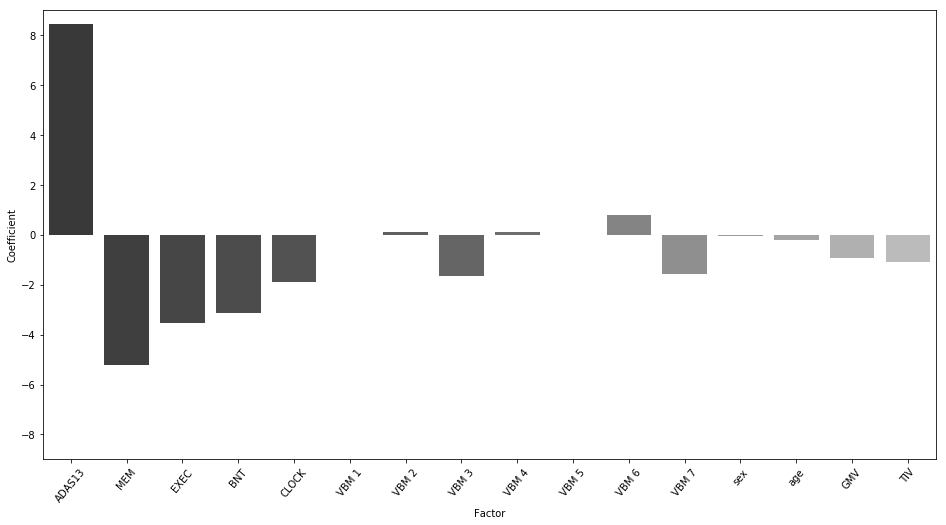

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8.27)

sns.factorplot(ax=ax, y='Coefficient', x='Factor', data=w_df, kind='bar', palette="Greys_d")
for item in ax.get_xticklabels():
    item.set_rotation(50)
ax.set_ylim(-9,9)
plt.close()
plt.show()

#### Get the predicted labels from HPS model

In [16]:
array_results, dic_results = hpc.predict(x_, x_)
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

### Generate ROC curves for classifiying AD vs CN in ADNI1

The following section of code was used to generate the ROC curves in Supplementary Figure 1 for the AD vs CN classification in the ADNI1 dataset.

#### Set up ROC curve for base SVM

In [17]:
# set the classifer and learn to predict AD vs CN
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)

# make sure to binarize the actual outputs
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve
fpr_b, tpr_b, thresholds_b = metrics.roc_curve(y_true, y_score, pos_label=1)
# Compute the AUC
roc_auc_b = auc(fpr_b, tpr_b)

#### Set up ROC curve for HPS model

In [18]:
# get the predicted output from HPS
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

# Compute the ROC curve
fpr_h, tpr_h, thresholds_h = metrics.roc_curve(y_true, y_score, pos_label=1)
# Compute the AUC
roc_auc_h = auc(fpr_h, tpr_h)

#### Plot both ROC curves for base SVM and HPS models

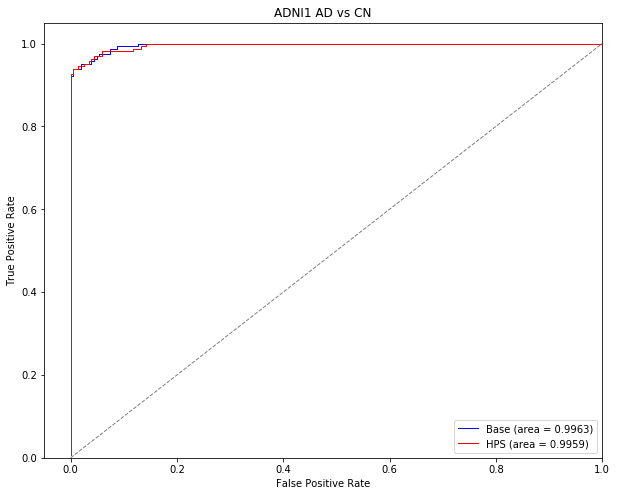

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b, tpr_b, color='blue',
         lw=lw, label='Base (area = %0.4f)' % roc_auc_b)
plt.plot(fpr_h, tpr_h, color='red',
         lw=lw, label='HPS (area = %0.4f)' % roc_auc_h)
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI1 AD vs CN')
plt.legend(loc="lower right")
plt.show()

# Test on ADNI1 MCI stable vs progressors

In this section, we will test our model on a new sample. This time, we will try to classify different types of patients with mild cognitive impairment (MCI). The task will be to distinguish between MCI patients who will progress to dementia within three years of follow-up from patients who will remain cognitvely stable. For now, we will do this in the MCI patients from the ADNI1 sample.

The followig code was used to generate the section of the paper titled *"High confidence prediction of progression to AD dementia"* in the *Results* for the ADNI1 subjects.

#### Organize the data

In [20]:
# grab only adni1
adni1_mci = data[data.dataset != 'ADNI2']

In [21]:
# grab only MCI
adni1_mci = adni1_mci[adni1_mci.DX != 'Dementia']
adni1_mci = adni1_mci[adni1_mci.DX != 'CN']

In [22]:
# set up the x variables
x_ = adni1_mci.iloc[:,adni1_mci.columns.get_loc("ADAS13"):adni1_mci.columns.get_loc("sub7")+1].values
# set up the y 
y_ = adni1_mci['conv_2_ad'].values.ravel()
# add these variables to the x
confounds = adni1_mci[['gender','age_scan','mean_gm','tiv']].values
# scale the x
x_ = scaler.transform(np.hstack((x_,confounds)))

#### Do the prediction

In [23]:
array_results, dic_results = hpc.predict(x_, x_)
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

#### Get the stats of the prediction

These stats are presented in the paper for the classification of stable MCI (non-target subjects) vs progressor MCI (target subjects) in the ADNI1 sample under the section *"High confidence prediction of progression to AD dementia"* in the *Results* of the paper. Stage 1 refers to the basic linear SVM model, while Stage 2 refers to the highly predictive signature (HPS) model.

In [24]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  147
Total number of NON-TARGET subjects:  88
Stage 1 number of hits (true and false positives):  129.0
Stage 1 TRUE positives:  117.0
Stage 1 FALSE positives:  12.0
Stage 1 TRUE negatives:  76.0
Total number of flagged HPC-AD subjects:  75.0
Number of flagged HPC-AD subjects that are TRUE positives:  70
Number of flagged HPC-AD subjects that are FALSE positives:  5.0
Number of true negatives:  83.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.9069767441860465
Recall (or sensitivity)  for AD:  0.7959183673469388
Specificity:  0.8636363636363636
Adjusted precision for 33.6% baseline rate:  0.7470613844144537
Accuracy:  0.8212765957446808
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.9333333333333333
Recall (or sensitivity) for HPC-AD:  0.47619047619047616
Specificity:  0.9431818181818182
Adjusted precision for 33.6% baseline rate:  0.8091954022988507
Accuracy:  0

(0.7959183673469388,
 0.8636363636363636,
 0.9069767441860465,
 0.8212765957446808,
 0.47619047619047616,
 0.9431818181818182,
 0.9333333333333333,
 0.6510638297872341)

### ROC curve for classification of stable vs progressor MCI in ADNI1

The following section of code was used to generate the ROC curves in Supplementary Figure 1 for the progressive MCI (pMCI) vs stable MCI (sMCI) classification in the ADNI1 dataset.

#### Set up for base SVM ROC curve

In [25]:
# set up the classifier
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)

# make sure to binarize the outputs
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve
fpr_b, tpr_b, thresholds_b = metrics.roc_curve(y_true, y_score, pos_label=1)
# Compute AUC
roc_auc_b = auc(fpr_b, tpr_b)

#### Set up the ROC curve for HPS model

In [26]:
# get the output of HPS model
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

# compute ROC curve
fpr_h, tpr_h, thresholds_h = metrics.roc_curve(y_true, y_score, pos_label=1)
# compute AUC
roc_auc_h = auc(fpr_h, tpr_h)

#### Plot the two ROC curves 

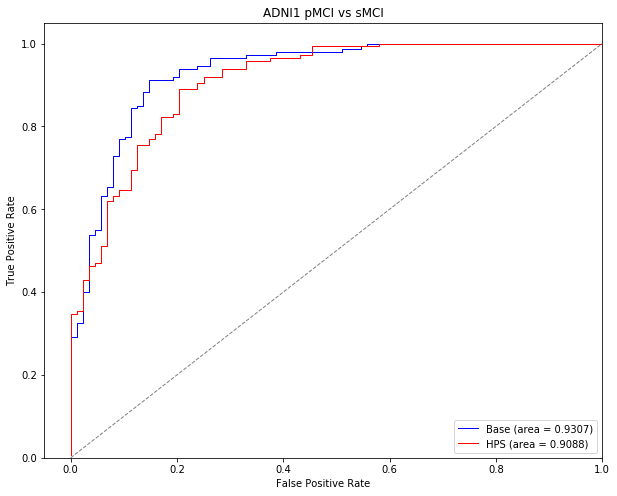

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b, tpr_b, color='blue',
         lw=lw, label='Base (area = %0.4f)' % roc_auc_b)
plt.plot(fpr_h, tpr_h, color='red',
         lw=lw, label='HPS (area = %0.4f)' % roc_auc_h)
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI1 pMCI vs sMCI')
plt.legend(loc="lower right")
plt.show()

# Replication in ADNI2 

In this section, we will replicate our results in a new independent sample: the ADNI2 cohort.

# Classify AD vs CN in ADNI2 with the model that was trained in ADNI1

First, we will classify AD vs CN in ADNI2 with the same model that had been trained to classify AD vs CN in ADNI1. These results are represented in the paper's sections *"Prediction of AD dementia vs cognitively normal individuals"* for the Stage 1 (basic linear SVM) model and *"Identification of easy AD cases for prediction"* for the Stage 2 (highly predictive signature/HPS) model.

#### Organize the data

In [28]:
# grab only adni2
adni2_adcn = data[data.dataset != 'ADNI1']

In [29]:
# grab only AD and CN
adni2_adcn = adni2_adcn[adni2_adcn.DX != 'pMCI']
adni2_adcn = adni2_adcn[adni2_adcn.DX != 'sMCI']

In [30]:
# set the x
x_ = adni2_adcn.iloc[:,adni2_adcn.columns.get_loc("ADAS13"):adni2_adcn.columns.get_loc("sub7")+1].values
# set the y
y_ = adni2_adcn[['AD']].values.ravel()
# add these variables to the x
confounds = adni2_adcn[['gender','age_scan','mean_gm','tiv']].values
# scale the x
x_ = scaler.transform(np.hstack((x_,confounds)))

#### Do the prediction

In [31]:
# get the predicted labels
array_results, dic_results = hpc.predict(x_, x_)
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

#### Get the stats of the classifcation of AD vs CN in ADNI2

These stats are presented in the paper for the classification of AD (target subjects) vs CN (non-target subjects) in ADNI2 under the *Results* section of the preprint. See "Prediction of AD dementia vs cognitively normal individuals" for the Stage 1 (basic linear SVM) model and "Identification of easy AD cases for prediction" for the Stage 2 (highly predictive signature/HPS) model.

In [32]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  88.0
Total number of NON-TARGET subjects:  188.0
Stage 1 number of hits (true and false positives):  88.0
Stage 1 TRUE positives:  82.0
Stage 1 FALSE positives:  6.0
Stage 1 TRUE negatives:  182.0
Total number of flagged HPC-AD subjects:  70.0
Number of flagged HPC-AD subjects that are TRUE positives:  70
Number of flagged HPC-AD subjects that are FALSE positives:  0.0
Number of true negatives:  188.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.9318181818181818
Recall (or sensitivity)  for AD:  0.9318181818181818
Specificity:  0.9680851063829787
Adjusted precision for 33.6% baseline rate:  0.9366060269407027
Accuracy:  0.9565217391304348
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  1.0
Recall (or sensitivity) for HPC-AD:  0.7954545454545454
Specificity:  1.0
Adjusted precision for 33.6% baseline rate:  1.0
Accuracy:  0.9347826086956522


(0.9318181818181818,
 0.9680851063829787,
 0.9318181818181818,
 0.9565217391304348,
 0.7954545454545454,
 1.0,
 1.0,
 0.9347826086956522)

### Generate ROC curves for AD vs CN in ADNI2

This section of code will generate the ROC curves presented in Supplementary Figure 1 for the classifcation of AD vs CN in the ADNI2 sample

#### Set up the ROC curve for base SVM

In [33]:
# set up classifier
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)

# make sure to binarize the outputs
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve
fpr_b, tpr_b, thresholds_b = metrics.roc_curve(y_true, y_score, pos_label=1)
# Compute AUC
roc_auc_b = auc(fpr_b, tpr_b)

#### Set up the ROC curve for the HPS model

In [34]:
# get the outputs from HPS model
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

# compute ROC curve
fpr_h, tpr_h, thresholds_h = metrics.roc_curve(y_true, y_score, pos_label=1)
# compute AUC
roc_auc_h = auc(fpr_h, tpr_h)

#### Plot the two curves

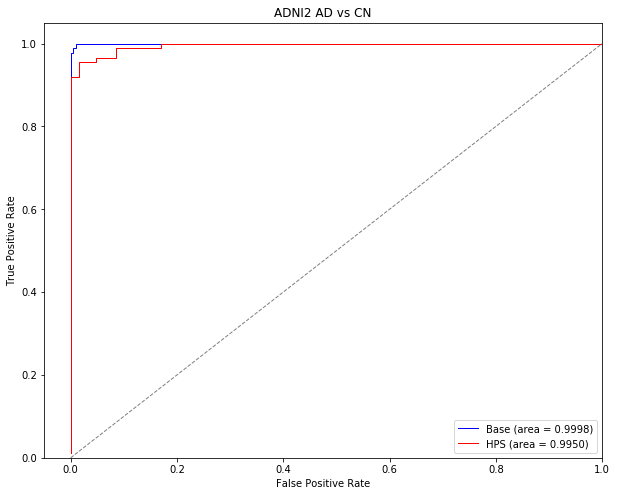

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b, tpr_b, color='blue',
         lw=lw, label='Base (area = %0.4f)' % roc_auc_b)
plt.plot(fpr_h, tpr_h, color='red',
         lw=lw, label='HPS (area = %0.4f)' % roc_auc_h)
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI2 AD vs CN')
plt.legend(loc="lower right")
plt.show()

# Classification of MCI stable vs progressors in ADNI2

We will now use the model we trained in ADNI1 on AD vs CN to classify stable MCI vs progressive MCI patients in the ADNI2 sample. This section displays the code that was used to generate the results within the section titled *"High confidence prediction of progression to AD dementia"* for ADNI2 subjects.

#### Organize the data

In [36]:
# grab adni2 subjects only
adni2_mci = data[data.dataset != 'ADNI1']

In [37]:
# grab the mci only
adni2_mci = adni2_mci[adni2_mci.DX != 'Dementia']
adni2_mci = adni2_mci[adni2_mci.DX != 'CN']

In [38]:
# set up the x
x_ = adni2_mci.iloc[:, adni2_mci.columns.get_loc("ADAS13"):adni2_mci.columns.get_loc("sub7")+1].values
# set up the y
y_ = adni2_mci[['conv_2_ad']].values.ravel()
# add these variables to the x
confounds = adni2_mci[['gender','age_scan','mean_gm','tiv']].values
# scale the x
x_ = scaler.transform(np.hstack((x_,confounds)))

#### Do the prediction

In [39]:
# get the predicted labels
array_results, dic_results = hpc.predict(x_, x_)
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

#### Stats for the prediction of stable vs progressor MCI in ADNI2

These stats are presented in the paper for the classification of stable MCI (non-target subjects) vs progressor MCI (target subjects) in the ADNI2 sample under the section "High confidence prediction of progression to AD dementia" in the Results of the paper. Stage 1 refers to the basic linear SVM model, while Stage 2 refers to the highly predictive signature (HPS) model.

In [40]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  55
Total number of NON-TARGET subjects:  180
Stage 1 number of hits (true and false positives):  68.0
Stage 1 TRUE positives:  42.0
Stage 1 FALSE positives:  26.0
Stage 1 TRUE negatives:  154.0
Total number of flagged HPC-AD subjects:  37.0
Number of flagged HPC-AD subjects that are TRUE positives:  28
Number of flagged HPC-AD subjects that are FALSE positives:  9.0
Number of true negatives:  171.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.6176470588235294
Recall (or sensitivity)  for AD:  0.7636363636363637
Specificity:  0.8555555555555555
Adjusted precision for 33.6% baseline rate:  0.727906283670709
Accuracy:  0.8340425531914893
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.7567567567567568
Recall (or sensitivity) for HPC-AD:  0.509090909090909
Specificity:  0.95
Adjusted precision for 33.6% baseline rate:  0.8374577176428698
Accuracy:  0.8468085106382979

(0.7636363636363637,
 0.8555555555555555,
 0.6176470588235294,
 0.8340425531914893,
 0.509090909090909,
 0.95,
 0.7567567567567568,
 0.8468085106382979)

#### These stats are presented in the paper for the classification of stable MCI (non-target subjects) vs progressor MCI (target subjects) in the ADNI2 sample

### Generate ROC curves

The following code will generate ROC curves for the sMCI vs pMCI classification in ADNI2. These curves are displayed in Supplementary Figure 1 of the preprint.

#### Set up the ROC curve for base SVM 

In [41]:
# set the classifier
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)

# make sure to binarize outputs
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve
fpr_b, tpr_b, thresholds_b = metrics.roc_curve(y_true, y_score, pos_label=1)
# Compute AUC
roc_auc_b = auc(fpr_b, tpr_b)

#### Set up the ROC curves for HPS model

In [42]:
# get the output for HPS model
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

# Compute ROC curve
fpr_h, tpr_h, thresholds_h = metrics.roc_curve(y_true, y_score, pos_label=1)
# Compute AUC
roc_auc_h = auc(fpr_h, tpr_h)

#### Plot the figure

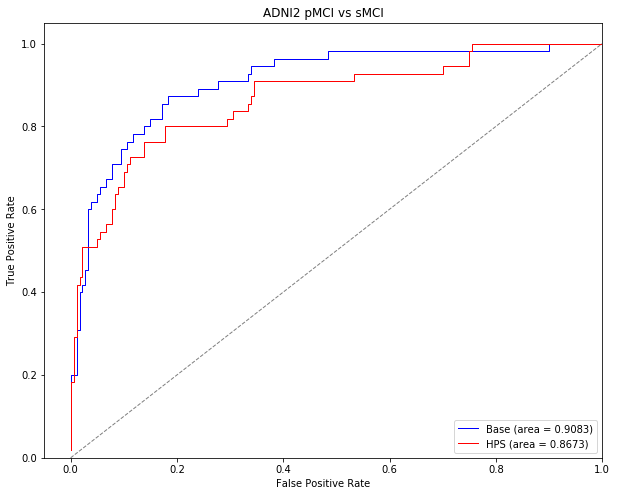

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b, tpr_b, color='blue',
         lw=lw, label='Base (area = %0.4f)' % roc_auc_b)
plt.plot(fpr_h, tpr_h, color='red',
         lw=lw, label='HPS (area = %0.4f)' % roc_auc_h)
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI2 pMCI vs sMCI')
plt.legend(loc="lower right")
plt.show()